In [2]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *

import statsmodels.formula.api as sm, statsmodels.stats.api as sms


from run_id import run_id

runstat = RunStats.objects.get(pk=run_id)

In [2]:


dts = DocTopic.objects.filter(
    run_id=run_id,
    doc__PY__lt=2014,
    score__gt=runstat.dthreshold
).values('topic__title')

dts = dts.annotate(
    ipcc = models.Sum(
        models.Case(
            models.When(doc__ipccref__isnull=False,then=F('score')),default=0, output_field=models.FloatField()
        )
    ),
    no_ipcc = models.Sum(
        models.Case(
            models.When(doc__ipccref__isnull=True,then=F('score')),default=0, output_field=models.FloatField()
        )
    )
)
df =  pd.DataFrame.from_dict(list(dts))

In [3]:
df['total'] = df.ipcc+df.no_ipcc
df['ipcc_pcnt'] = df.ipcc/df.total*100
df = df.sort_values(by='ipcc_pcnt', ascending=0).reset_index(drop=True)
df.head()

,ipcc,no_ipcc,topic__title,total,ipcc_pcnt
0,79.255687,151.767158,"{aerosol, forc, radiat}",231.022844,34.306428
1,64.254971,155.017713,"{adapt, vulner, strategi}",219.272683,29.303682
2,84.535940,229.621940,"{scenario, project, futur}",314.157879,26.908744
3,48.701467,136.883693,"{ozon, stratospher, tropospher}",185.585160,26.242113
4,43.362495,126.577861,"{cloud, feedback, radiat}",169.940356,25.516303


In [7]:
df = pd.DataFrame.from_dict(
        list(Topic.objects.filter(
            run_id=run_id,
            topicarscores__ar=5,
            topicarscores__share__gt=0.005
        ).order_by('-ipcc_coverage').values('title','ipcc_coverage'))
)

df.head()

,ipcc_coverage,title
0,0.343064,"{aerosol, forc, radiat}"
1,0.293037,"{adapt, vulner, strategi}"
2,0.269087,"{scenario, project, futur}"
3,0.262421,"{ozon, stratospher, tropospher}"
4,0.255163,"{cloud, feedback, radiat}"


0.1268951271


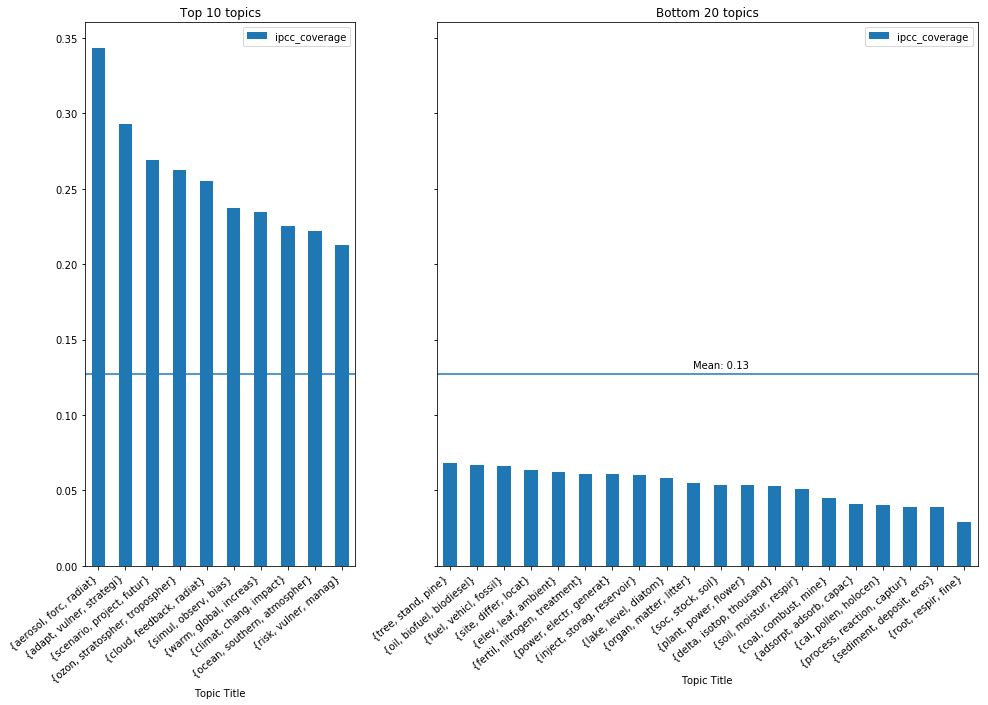

In [27]:
plt.rcParams["figure.figsize"] = [16,10]

# plot it
fig = plt.figure(figsize=(16, 10)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharey=ax0)

axs = [ax0,ax1]

nn = 15


i=0
for ax in axs:

    bdf = df.set_index(['title'])[['ipcc_coverage']]
    
    print(bdf['ipcc_coverage'].mean())

    m = bdf['ipcc_coverage'].mean()
    
    #ax.set_ylim([0, 20])
    
    if i==0:
        n = nn-5
        bdf.head(n).plot.bar(ax=ax)
        ax.set_title('Top {} topics'.format(n))
    else:
        n = nn+5
        bdf.tail(n).plot.bar(ax=ax)
        ax.set_title('Bottom {} topics'.format(n))
        ax.text(n/2,m*1.05,"Mean: {}".format(round(m,2)),ha="center",va="center")
    ax.axhline(y=m)
        
    i+=1
    
    ax.set_xlabel('Topic Title')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
plt.xlabel('Topic Title')

plt.savefig('../plots/ipcc_topics_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

In [18]:
df = pd.DataFrame.from_dict(
        list(Topic.objects.filter(
            run_id=run_id,
            topicarscores__ar=5,
            topicarscores__share__gt=0.005
        ).order_by('-ipcc_coverage').values('title','ipcc_coverage','primary_wg','wg_1','wg_2','wg_3'))
)

df.head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3
0,0.343064,1,"{aerosol, forc, radiat}",0.835755,0.103747,0.060498
1,0.293037,2,"{adapt, vulner, strategi}",0.019874,0.864130,0.115995
2,0.269087,2,"{scenario, project, futur}",0.345093,0.529974,0.124934
3,0.262421,1,"{ozon, stratospher, tropospher}",0.779407,0.164467,0.056126
4,0.255163,1,"{cloud, feedback, radiat}",0.883814,0.085763,0.030423


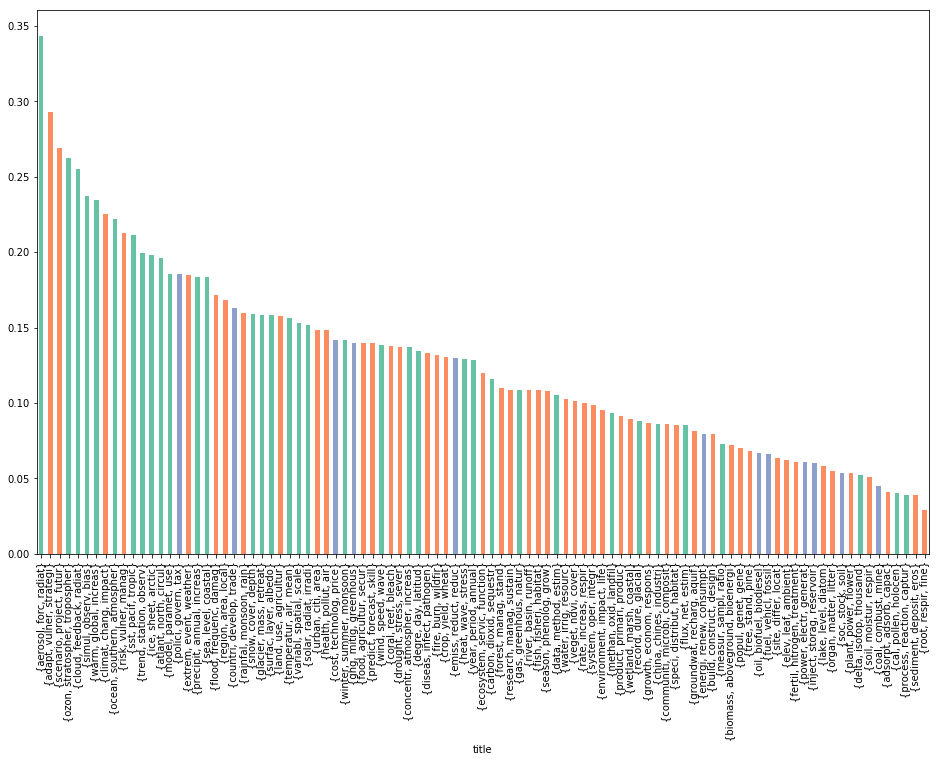

In [20]:
plt.rcParams["figure.figsize"] = [16,10]

colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

bdf = df.set_index(['title'])

bdf['ipcc_coverage'].plot(kind='bar', color=[colors[i] for i in bdf['primary_wg']])

plt.show()

In [12]:
soil_tops = Topic.objects.filter(
    topicterm__run_id=run_id,
    topicterm__term__title="soil"
)
print(soil_tops.count())

soil_tops

9


<QuerySet [<Topic: {biochar, amend, pyrolysi}>, <Topic: {root, respir, fine}>, <Topic: {wetland, marsh, coastal}>, <Topic: {rice, paddi, field}>, <Topic: {soc, stock, soil}>, <Topic: {fertil, nitrogen, treatment}>, <Topic: {land, use, agricultur}>, <Topic: {crop, yield, wheat}>, <Topic: {soil, moistur, respir}>]>

In [35]:
mixtures = Topic.objects.filter(
    run_id=run_id
).order_by('-ipcc_coverage').values('title','primary_wg','wg_prop','wg_1','wg_2','wg_3','ipcc_coverage')

df = pd.DataFrame.from_dict(list(mixtures))
df['WG 1'] = df['ipcc_coverage'] * df['wg_1']
df['WG 2'] = df['ipcc_coverage'] * df['wg_2']
df['WG 3'] = df['ipcc_coverage'] * df['wg_3']


df.head(20)

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,wg_prop,WG 1,WG 2,WG 3
0,0.343064,1,"{aerosol, forc, radiat}",0.835755,0.103747,0.060498,0.835755,0.286718,0.035592,0.020755
1,0.293037,2,"{adapt, vulner, strategi}",0.019874,0.864130,0.115995,0.864130,0.005824,0.253222,0.033991
2,0.269087,2,"{scenario, project, futur}",0.345093,0.529974,0.124934,0.529974,0.092860,0.142609,0.033618
3,0.262421,1,"{ozon, stratospher, tropospher}",0.779407,0.164467,0.056126,0.779407,0.204533,0.043160,0.014729
4,0.255163,1,"{cloud, feedback, radiat}",0.883814,0.085763,0.030423,0.883814,0.225517,0.021884,0.007763
5,0.237478,1,"{simul, observ, bias}",0.706074,0.266051,0.027876,0.706074,0.167677,0.063181,0.006620
6,0.234207,1,"{warm, global, increas}",0.546531,0.367328,0.086141,0.546531,0.128001,0.086031,0.020175
7,0.225379,2,"{climat, chang, impact}",0.336905,0.559576,0.103519,0.559576,0.075931,0.126117,0.023331
8,0.221696,1,"{ocean, southern, atmospher}",0.729657,0.247664,0.022679,0.729657,0.161762,0.054906,0.005028
9,0.212693,2,"{risk, vulner, manag}",0.064194,0.789955,0.145851,0.789955,0.013654,0.168018,0.031021


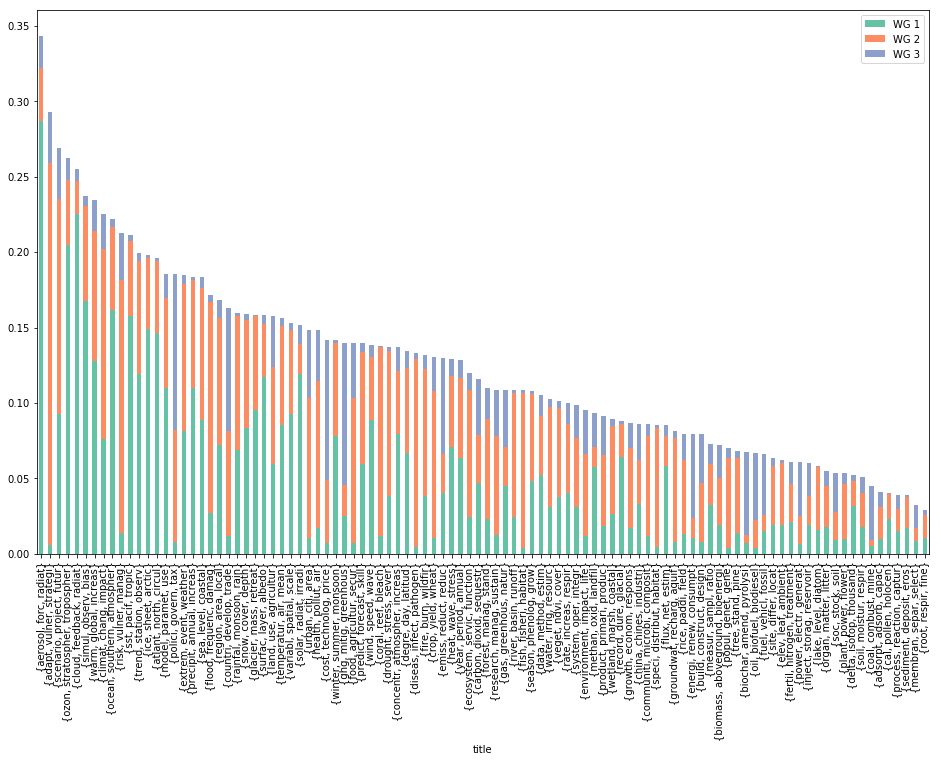

In [36]:
plt.rcParams["figure.figsize"] = [16,10]

colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

colors = ["#66c2a5","#fc8d62","#8da0cb"]

bdf = df.set_index(['title'])

#bdf['ipcc_coverage'].plot(kind='bar', color=[colors[i] for i in bdf['primary_wg']])

bdf[['WG 1','WG 2','WG 3']].plot(kind='bar', stacked=True, color = colors)

plt.savefig('../plots/ipcc_topics_wg_{}.png'.format(run_id),bbox_inches='tight')   


plt.show()

In [51]:
df['wg1_3'] = df['wg_1'] * df['wg_3']
df['wg1_2'] = df['wg_1'] * df['wg_2']
df['wg2_3'] = df['wg_2'] * df['wg_3']

df.sort_values('wg1_3',ascending=False).head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,wg_prop,WG 1,WG 2,WG 3,wg1_3,wg1_2,wg2_3
45,0.129641,3,"{emiss, reduct, reduc}",0.309014,0.201038,0.489948,0.489948,0.040061,0.026063,0.063517,0.151401,0.062124,0.098498
62,0.093345,1,"{methan, oxid, landfil}",0.614474,0.142063,0.243463,0.614474,0.057358,0.013261,0.022726,0.149602,0.087294,0.034587
52,0.108736,1,"{gas, greenhous, natur}",0.413376,0.236773,0.349851,0.413376,0.044949,0.025746,0.038041,0.144620,0.097876,0.082835
81,0.066049,3,"{fuel, vehicl, fossil}",0.230055,0.163106,0.606839,0.606839,0.015195,0.010773,0.040081,0.139606,0.037523,0.098979
49,0.115682,1,"{carbon, dioxid, sequestr}",0.404981,0.276954,0.318065,0.404981,0.046849,0.032039,0.036795,0.128810,0.112161,0.088089


In [46]:
df.sort_values('wg1_2',ascending=False).head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,wg_prop,WG 1,WG 2,WG 3,wg1_3,wg1_2,wg2_3
33,0.141770,1,"{winter, summer, monsoon}",0.551575,0.436577,0.011848,0.551575,0.078197,0.061894,0.001680,0.006535,0.240805,0.190600
22,0.159727,2,"{rainfal, monsoon, rain}",0.430418,0.558624,0.010957,0.558624,0.068749,0.089227,0.001750,0.004716,0.240442,0.312061
55,0.107822,2,"{season, phenolog, grow}",0.446916,0.533995,0.019089,0.533995,0.048187,0.057576,0.002058,0.008531,0.238651,0.285150
24,0.158394,1,"{glacier, mass, retreat}",0.602415,0.393846,0.003740,0.602415,0.095419,0.062383,0.000592,0.002253,0.237258,0.155114
95,0.040377,1,"{cal, pollen, holocen}",0.565536,0.419279,0.015185,0.565536,0.022834,0.016929,0.000613,0.008588,0.237118,0.175795


In [52]:
df.sort_values('wg2_3',ascending=False).head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,wg_prop,WG 1,WG 2,WG 3,wg1_3,wg1_2,wg2_3
15,0.185236,3,"{polici, govern, tax}",0.044249,0.399115,0.556636,0.556636,0.008196,0.073930,0.103109,0.024630,0.017660,0.222162
21,0.162633,3,"{countri, develop, trade}",0.074721,0.428138,0.497140,0.497140,0.012152,0.069629,0.080851,0.037147,0.031991,0.212845
74,0.079268,2,"{build, construct, design}",0.095940,0.494182,0.409878,0.494182,0.007605,0.039173,0.032490,0.039324,0.047412,0.202554
32,0.141840,3,"{cost, technolog, price}",0.049551,0.297264,0.653185,0.653185,0.007028,0.042164,0.092647,0.032366,0.014730,0.194168
30,0.148464,2,"{urban, citi, area}",0.073300,0.623049,0.303651,0.623049,0.010882,0.092500,0.045081,0.022258,0.045669,0.189189


In [71]:
pd.options.display.float_format = '{:.2f}%'.format

tabdf = df[['ipcc_coverage','primary_wg','title','wg_1','wg_2','wg_3','wg1_2','wg1_3','wg2_3']]

tabdf = tabdf.rename(columns={
    'ipcc_coverage':'IPCC Coverage','primary_wg':'Primary WG','title':'Topic Title',
    'wg_1':'WG 1','wg_2': 'WG 2','wg_3': 'WG 3'
})

cformat = 'p{1.4cm} p{1cm} l r r r'

tabdf.sort_values('wg1_2',ascending=False)
ttabdf = tabdf[['IPCC Coverage','Primary WG','Topic Title','WG 1','WG 2','WG 3']]
ttabdf.head().to_latex('../tables/{}_wg_1_2.tex'.format(run_id),column_format=cformat)

tabdf.sort_values('wg1_3',ascending=False)
ttabdf = tabdf[['IPCC Coverage','Primary WG','Topic Title','WG 1','WG 2','WG 3']]
ttabdf.head().to_latex('../tables/{}_wg_1_3.tex'.format(run_id,column_format=cforma))

tabdf.sort_values('wg2_3',ascending=False)
ttabdf = tabdf[['IPCC Coverage','Primary WG','Topic Title','WG 1','WG 2','WG 3']]
ttabdf.head().to_latex('../tables/{}_wg_2_3.tex'.format(run_id,column_format=cforma))



ttabdf.head()


NameError: name 'cforma' is not defined

In [ ]:
ipccdocs = DocTopic.objects.filter(
    doc__ipccref__isnull=False,
    run_id=run_id
).values('topic__title','doc__ipccref__ar','doc__ipccref__wg__wg').annotate(
    score=Sum('score'),
    count=Count('doc',distinct=True)
)
ipdf_tops =  pd.DataFrame.from_dict(list(ipccdocs)).rename(columns={'doc__ipccref__ar':'AR','doc__ipccref__wg__wg':'WG'})
#ipdf.head()

In [ ]:
wgtcounts = DocTopic.objects.filter(
    doc__ipccref__isnull=False,
    run_id=run_id
).values('doc__ipccref__ar','doc__ipccref__wg__wg').annotate(
    wgt_score=Sum('score'),
    wgt_count=Count('doc',distinct=True)
)
wgtc =  pd.DataFrame.from_dict(list(wgtcounts)).rename(columns={'doc__ipccref__ar':'AR','doc__ipccref__wg__wg':'WG'})
wgtc.head()

In [ ]:
wgcounts = IPCCRef.objects.all().values('ar','wg__wg').annotate(
    wg_count=Count('pk',distinct=True)
)
wgc =  pd.DataFrame.from_dict(list(wgcounts)).rename(columns={'ar':'AR','wg__wg':'WG'})
wgc.head(15)

In [ ]:
ipdf = ipdf_tops.merge(wgc).merge(wgtc)
ipdf.head()

In [ ]:
plt.rcParams["figure.figsize"] = [16,10]

fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    sharey=True
)

grouped = ipdf.groupby('WG')

targets = zip(grouped.groups.keys(), axs.flatten())

n = 12

for i, (key, ax) in enumerate(targets):
#for name, group in ipdf.groupby('WG'):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('WG {:.0f} topics'.format(key))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [16,24]

fig, axs = plt.subplots(
    nrows=4,
    ncols=1,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)

grouped = ipdf[ipdf['WG']==3].groupby('AR')

targets = zip(range(2,6), axs.flatten())

n = 25

for i, (key, ax) in enumerate(targets):
#for name, group in ipdf.groupby('WG'):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('AR {:.0f} topics'.format(key))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [16,24]

fig, axs = plt.subplots(
    nrows=4,
    ncols=3,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)

grouped = ipdf.dropna().sort_values(['AR','WG']).groupby(['AR','WG'])

arorder = []
for x in range(2,6):
    for y in range(1,4):
        arorder.append((float(x),float(y)))

targets = zip(arorder, axs.flatten())

n = 12

for i, (key, ax) in enumerate(targets):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('AR {:.0f} WG {:.0f} topics'.format(key[0],key[1]))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_xlabel('Topic Title')
    text = "{} out of {} references".format(group['wgt_count'][0],group['wg_count'][0])
    ax.text(n-1,8,text,ha="right")

plt.tight_layout()

plt.savefig('../plots/ipcc_topics_ars_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

plt.show()

In [ ]:
wg3 = ipdf[ipdf['WG']==3].dropna().sort_values(['AR','WG'])

wg3['share'] = wg3['score'] / wg3['wgt_score']*100

wg3 = wg3[wg3['share']>2]

wg3 = wg3[wg3['AR']>1]

wg3 = pd.pivot_table(
                wg3,
                values='share',
                index='AR',
                columns='topic__title'
            )
wg3.head()

fig, ax = plt.subplots()

#ax = enumerate(axs)[0]

wg3.plot.bar(stacked=True,ax=ax)

handles, labels = ax.get_legend_handles_labels()

lpos = (1.1,0.75)

ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=lpos, loc=2, borderaxespad=.0,)

plt.show()

In [14]:
wgs = [
    {"WG":1, "score": 0},
    {"WG":2, "score": 0},
    {"WG":3, "score": 0}
]
for topic in Topic.objects.filter(run_id=run_id):
    tdocs = Doc.objects.filter(doctopic__topic=topic,doctopic__score__gt=runstat.dthreshold)
    for wg in wgs:
        wgdocs = tdocs.filter(ipccref__wg__wg=wg["WG"])
        if wgdocs.count() == 0:
            wg['score'] = 0
        else:
            wg['score'] = wgdocs.aggregate(s = Sum('doctopic__score'))['s']       
    maxwg =  max(wgs, key=lambda x:x['score'])
    tscore = sum(x['score'] for x in wgs)
    if tscore==0:
        tscore=1
    topic.wg_1 = wgs[0]['score'] / tscore
    topic.wg_2 = wgs[1]['score'] / tscore
    topic.wg_3 = wgs[2]['score'] / tscore
    topic.primary_wg = maxwg['WG']
    topic.wg_prop = maxwg['score'] / tscore
    topic.save()

In [54]:
wgdts = DocTopic.objects.filter(topic__run_id=run_id).values('doc__PY','topic__title').annotate(
    score = Sum('score')
)


wgpy = pd.DataFrame.from_dict(list(wgdts.values('topic__title','score','doc__PY','topic__wg_1','topic__wg_2','topic__wg_3')))

wgpy.head()

,doc__PY,score,topic__title,topic__wg_1,topic__wg_2,topic__wg_3
0,2008,10.950480,"{coral, reef, bleach}",0.084144,0.911041,0.004815
1,2009,7.583248,"{rice, paddi, field}",0.163598,0.615590,0.220812
2,2012,24.110573,"{rainfal, monsoon, rain}",0.430418,0.558624,0.010957
3,2014,42.303584,"{gas, greenhous, natur}",0.413376,0.236773,0.349851
4,2006,12.977260,"{sea, level, coastal}",0.483224,0.479534,0.037242


In [ ]:
wgpy_dict = []

for py in range(1990,2017):
    for wg in wgs:
        wgscore = 0
        for t in wgdts.values('topic__id','doc__PY','score').filter(doc__PY=py):
            top = Topic.objects.get(id=t['topic__id'])
            score = t['score'] * getattr(top,"wg_{}".format(wg['WG']))
            wgscore += score
        wgpy_dict.append({
            'PY': py,
            'WG': wg['WG'],
            'score': wgscore
        })

In [ ]:
plt.rcParams["figure.figsize"] = [16,10]

wgpy = pd.DataFrame.from_dict(wgpy_dict)

wgpy.head()

wgpy_wide = pd.pivot_table(
    data=wgpy,
    index='PY',
    columns='WG',
    values='score'
)

wgpy_wide.head()

wgpy_wide.plot()

plt.show()




In [53]:
tword = "biochar"

sus = Topic.objects.filter(run_id=run_id,title__icontains=tword)

print(sus.count())

sus_scores = []

for py in range(1990,2017):
    for wg in wgs:
        wgscore = 0
        for t in wgdts.values('topic__id','doc__PY','score').filter(doc__PY=py,topic__in=sus):
            top = Topic.objects.get(id=t['topic__id'])
            score = t['score'] * getattr(top,"wg_{}".format(wg['WG']))
            wgscore += score
        sus_scores.append({
            'PY': py,
            'WG': wg['WG'],
            'score': wgscore
        })
sus_df = pd.DataFrame.from_dict(sus_scores)

sus_wide = pd.pivot_table(
    data=sus_df,
    index='PY',
    columns='WG',
    values='score'
)

sus_wide.plot()

plt.title(tword)

plt.show()


1


NameError: name 'wgdts' is not defined

In [ ]:
iprs = Doc.objects.filter(ipccref__isnull=False).values('PY','ipccref__wg__wg').annotate(
    n = Count('UT')
)

ippy = pd.DataFrame.from_dict(list(iprs))

ippy_wide = pd.pivot_table(
    data=ippy,
    index='PY',
    columns='ipccref__wg__wg',
    values='n'
)


ippy_wide.plot()

plt.show()

In [ ]:
tcs = TopicCorr.objects.filter(run_id=run_id).filter(score__gt=0.05,score__lt=1).annotate(
        source=F('topic'),
        target=F('topiccorr')
    )



tcdf = pd.DataFrame.from_dict(list(tcs.values('topic','topiccorr','topic__primary_wg','topiccorr__primary_wg','score')))

def issame(x):
    if x['topic__primary_wg']==x['topiccorr__primary_wg']:
        return 1
    else:
        return 0

tcdf['samewg'] = tcdf.apply(lambda x: issame(x) ,axis=1)

tcdf.head()

In [ ]:
result = sm.ols(formula="score ~ samewg + topic__primary_wg", data=tcdf).fit()

print(result.summary())

In [ ]:
X1, X2 = np.arange(10,21), np.arange(20,26.5,.5)

cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
print(cm.tconfint_diff(usevar='unequal'))

In [ ]:
from scipy.stats import ttest_ind

cat1 = tcdf[tcdf['samewg']==1]
cat2 = tcdf[tcdf['samewg']==0]


ttest_ind(cat1['score'], cat2['score'])

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]

gp = tcdf[['score','samewg']].groupby('samewg')

means = gp.mean()

print(means)

errors = gp.std()

print(errors)

fig, ax = plt.subplots()

means.plot(yerr=errors, ax=ax, kind='bar')

plt.show()


In [ ]:
dts = DocTopic.objects.filter(run_id=run_id)

df = pd.DataFrame(list(dts.values('doc_id','topic_id','score')))

df = df.pivot(index='doc_id',columns='topic_id',values='score').fillna(0)

corr = df.corr()

corr['topic1'] = corr.index


In [ ]:
topics = Topic.objects.filter(run_id=run_id)
tdf = pd.DataFrame.from_dict(list(topics.values('id','primary_wg')))


tdf.head()

In [ ]:
corrlong = pd.melt(corr,id_vars=['topic1'])
corrlong = corrlong[corrlong['value']<1]

mask = corrlong['topic1'] < corrlong['topic_id']

corrlong['first'] = corrlong['topic1'].where(mask, corrlong['topic_id'])
corrlong['second'] = corrlong['topic_id'].where(mask, corrlong['topic1'])

corrlong = corrlong.drop_duplicates(subset=['value', 'first', 'second'])[['topic1','topic_id','value']].rename(columns={
    'topic1':'topic1','topic_id':'topic2'
})

tdf1 = tdf.rename(columns={
    'id':'topic1',
    'primary_wg': 'wg_1'
})

tdf2 = tdf.rename(columns={
    'id':'topic2',
    'primary_wg': 'wg_2'
})

corrlong = corrlong.merge(tdf1).merge(tdf2)

def issame(x):
    if x['wg_1']==x['wg_2']:
        return 1
    else:
        return 0

corrlong['samewg'] = corrlong.apply(lambda x: issame(x) ,axis=1)


corrlong.head()

In [ ]:
gp = corrlong[['value','samewg']].groupby('samewg')

means = gp.mean()

print(means)

errors = gp.std()

print(errors)

fig, ax = plt.subplots()

means.plot(yerr=errors, ax=ax, kind='bar')

plt.show()

In [ ]:
from scipy.stats import ttest_ind

cat1 = corrlong[corrlong['samewg']==1]
cat2 = corrlong[corrlong['samewg']==0]


ttest_ind(cat1['value'], cat2['value'])